#1) The training of a **model on the dataset as is



In [1]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [3]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(size=(32,32)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224), #centre crop has to be smaller than og size
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5], #this for CIFOS but for the fruit data use diff values
         #                    [0.5, 0.5, 0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(32,32)),
      #  transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [4]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/gdrive/MyDrive/fruit_dataset/'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [5]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [6]:
train_data_size, test_data_size

(521, 323)

In [7]:
input_size = (3,32,32)

In [8]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=8, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=8, 
                                    num_workers=0, 
                                    shuffle=False,) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [9]:
#1. DEFINE THE CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.batchnorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        #op is 23 --> 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) #max pool1
        #x = self.batchnorm1(x)
        x = self.pool(self.relu(self.conv2(x))) 
        #x = self.batchnorm2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
model = CNN()
# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (relu): ReLU()
)

In [11]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [12]:
# 4. Train the model for 10 epoch
 
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 1.3300, Accuracy: 39.5393%, 
		Validation : Loss : 1.4029, Accuracy: 15.4799%, Time: 402.4527s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.1484, Accuracy: 42.0345%, 
		Validation : Loss : 1.7733, Accuracy: 15.4799%, Time: 2.2868s
Epoch: 3/30
Epoch : 002, Training: Loss: 1.0289, Accuracy: 41.6507%, 
		Validation : Loss : 1.8189, Accuracy: 15.4799%, Time: 2.1805s
Epoch: 4/30
Epoch : 003, Training: Loss: 1.0176, Accuracy: 41.8426%, 
		Validation : Loss : 1.7342, Accuracy: 17.6471%, Time: 2.2121s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.9842, Accuracy: 47.0250%, 
		Validation : Loss : 1.7153, Accuracy: 18.2663%, Time: 2.2217s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.9520, Accuracy: 51.4395%, 
		Validation : Loss : 1.6287, Accuracy: 19.8142%, Time: 2.2192s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.9072, Accuracy: 56.2380%, 
		Validation : Loss : 1.5277, Accuracy: 43.0341%, Time: 2.2775s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.8728, Accuracy: 6

#2) The training of the model on the dataset after modification to improve the performance of the model.

>using pretrained model (Resnet)

In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(size=(32,32)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224), #centre crop has to be smaller than og size
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5], #this for CIFOS but for the fruit data use diff values
         #                    [0.5, 0.5, 0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(32,32)),
      #  transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/gdrive/MyDrive/fruit_dataset/'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 7

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
train_data_size, test_data_size

(521, 323)

In [ ]:
input_size = (3,32,32)

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=7, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=7, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
#######################
# DEFINE YOUR OWN MODEL
#######################
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        #self.conv1_drop = nn.Dropout1d()
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
           if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.relu(self.fc0(output))
        output = self.bn1(output)
        output = self.relu(self.classifier(output))
                
        return output

model = MyCustomResnet18()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomResnet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'Assignment2_model'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 1.4018, Accuracy: 44.1459%, 
		Validation : Loss : 1.3255, Accuracy: 50.1548%, Time: 151.4703s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.1279, Accuracy: 56.6219%, 
		Validation : Loss : 1.1190, Accuracy: 58.2043%, Time: 17.0861s
Epoch: 3/30
Epoch : 002, Training: Loss: 1.0448, Accuracy: 63.5317%, 
		Validation : Loss : 0.9833, Accuracy: 63.7771%, Time: 17.8449s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.9291, Accuracy: 65.4511%, 
		Validation : Loss : 1.1747, Accuracy: 58.5139%, Time: 17.1119s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.8588, Accuracy: 70.0576%, 
		Validation : Loss : 1.2375, Accuracy: 59.7523%, Time: 19.5596s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.8921, Accuracy: 69.0979%, 
		Validation : Loss : 1.0391, Accuracy: 63.1579%, Time: 17.7525s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.7641, Accuracy: 73.1286%, 
		Validation : Loss : 0.8988, Accuracy: 67.8019%, Time: 16.8634s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.6721, Accur

>Epoch: 30/30
Epoch : 029, Training: Loss: 0.3685, Accuracy: 87.3321%, 
		Validation : Loss : 1.0545, Accuracy: 63.4675%, Time: 17.7356s

#3) The training of the model on the dataset after data-centric strategies

In [ ]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

!gdown https://drive.google.com/uc?id=1yHgmyJ-VOJZKpPoVsXWNEF_EZPxtPAfx


Downloading...
From: https://drive.google.com/uc?id=1yHgmyJ-VOJZKpPoVsXWNEF_EZPxtPAfx
To: /content/fruits_fixedfinal.zip
100% 29.5M/29.5M [00:00<00:00, 92.3MB/s]


In [ ]:

!unzip  fruits_fixedfinal.zip -d /content/gdrive/MyDrive/fruits_fixedfinal
#use dataset path as ;   /content/gdrive/MyDrive/fruit_dataset

Archive:  fruits_fixedfinal.zip
replace /content/gdrive/MyDrive/fruits_fixedfinal/fruits_fixedfinal/train/durian/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#run CNN

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
       # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(size=(32,32)),
        #transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224), #centre crop has to be smaller than og size
        transforms.ToTensor(),
        #transforms.Normalize([0.5, 0.5, 0.5], #this for CIFOS but for the fruit data use diff values
         #                    [0.5, 0.5, 0.5])
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(32,32)),
      #  transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/gdrive/MyDrive/fruits_fixedfinal/fruits_fixedfinal'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 7

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
train_data_size, test_data_size

(1600, 400)

In [ ]:
input_size = (3,32,32)

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=7, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=7, 
                                    num_workers=0, 
                                    shuffle=False,) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

1600
400


In [ ]:
#######################
# DEFINE YOUR OWN MODEL
#######################
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
      #  self.conv1_drop = nn.Dropout1d()
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
           if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.relu(self.fc0(output))
        output = self.bn1(output)
       # output = self.conv1_drop(output)
        output = self.relu(self.classifier(output))
                
        return output

model = MyCustomResnet18()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomResnet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'fruitCNNdata'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
# 4. Train the model for 10 epoch
 
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)



new highest:

Epoch: 28/30
Epoch : 027, Training: Loss: 0.0713, Accuracy: 97.8125%, 
		Validation : Loss : 0.2833, Accuracy: 91.2500%, Time: 10.1035s

#4) Save the final model and load again on the notebook. Perform inference on 3 new samples (fruit data captured from your phone).

In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms

In [ ]:
# Specify image transformations
from torchvision import transforms

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])


In [ ]:
#get the 3 images
!wget https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/268.jpg -O watermelon.jpg
file_name1 = "watermelon.jpg"


--2022-07-25 14:20:38--  https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/268.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8056 (7.9K) [image/jpeg]
Saving to: ‘watermelon.jpg’

watermelon.jpg      100%[===================>]   7.87K  --.-KB/s    in 0s      

2022-07-25 14:20:38 (69.7 MB/s) - ‘watermelon.jpg’ saved [8056/8056]



In [ ]:
!wget https://github.com/amirahazani/KPT-MLAssignments/blob/main/Week2/267.jpg?raw=true -O tomato.jpg
file_name2 = "tomato.jpg"


--2022-07-25 14:20:38--  https://github.com/amirahazani/KPT-MLAssignments/blob/main/Week2/267.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/amirahazani/KPT-MLAssignments/raw/main/Week2/267.jpg [following]
--2022-07-25 14:20:38--  https://github.com/amirahazani/KPT-MLAssignments/raw/main/Week2/267.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/267.jpg [following]
--2022-07-25 14:20:39--  https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/267.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [ ]:

!wget https://github.com/amirahazani/KPT-MLAssignments/blob/main/Week2/494.jpg?raw=true -O durian.jpg
file_name3 = "durian.jpg"

--2022-07-25 15:14:28--  https://github.com/amirahazani/KPT-MLAssignments/blob/main/Week2/494.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/amirahazani/KPT-MLAssignments/raw/main/Week2/494.jpg [following]
--2022-07-25 15:14:28--  https://github.com/amirahazani/KPT-MLAssignments/raw/main/Week2/494.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/494.jpg [following]
--2022-07-25 15:14:28--  https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/494.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

In [ ]:
# Download classes text file

!wget https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/fruitsclasses.txt
file_name = 'fruits_classes.txt'
# download(url, file_name)

--2022-07-25 15:01:38--  https://raw.githubusercontent.com/amirahazani/KPT-MLAssignments/main/Week2/fruitsclasses.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32 [text/plain]
Saving to: ‘fruitsclasses.txt’

fruitsclasses.txt   100%[===================>]      32  --.-KB/s    in 0s      

2022-07-25 15:01:38 (2.37 MB/s) - ‘fruitsclasses.txt’ saved [32/32]



In [ ]:
from requests import get  # to make GET request

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

In [ ]:
# from PIL import Image
# img = Image.open("dog.jpg")

import cv2
img1 = cv2.imread("watermelon.jpg")
img2 = cv2.imread("tomato.jpg")
img3 = cv2.imread("durian.jpg")

In [ ]:
img_t1 = transform(img1)
batch_t1 = torch.unsqueeze(img_t1, 0)

img_t2 = transform(img2)
batch_t2 = torch.unsqueeze(img_t2, 0)

img_t3 = transform(img3)
batch_t3 = torch.unsqueeze(img_t3, 0)

In [ ]:
# Put our model in eval mode
model.eval()

MyCustomResnet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
# Carry out inference
out1 = model(batch_t1)
out2 = model(batch_t2)
out3 = model(batch_t3)


print(out1.shape)
print(out2.shape)
print(out3.shape)

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


In [ ]:
with open('fruitsclasses.txt') as f:
    lines = f.readlines()

In [ ]:
# Load labels
with open('fruitsclasses.txt') as f:
  classes = [line.strip() for line in f.readlines()]

In [ ]:
class_names = open("fruitsclasses.txt").read().split("\n")

print(class_names[:4])

['Durian', 'Pumpkin', 'Tomato', 'Watermelon']


Watermelon 0.6662355661392212
Tomato 0.17904885113239288
Pumpkin 0.08424802124500275
Durian 0.0704675242304802


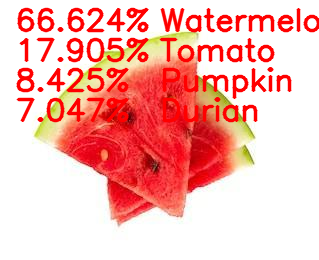

In [ ]:
from google.colab.patches import cv2_imshow

# Get the softmax probabilities.
probabilities1 = torch.nn.functional.softmax(out1, dim=1)[0]

# Check the top 5 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities1, 4)


for i in range(top4_prob.size(0)):
    cv2.putText(img1, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img1, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())



    
cv2_imshow(img1)

cv2.waitKey(0)
cv2.destroyAllWindows()

Tomato 0.748346745967865
Watermelon 0.14812003076076508
Durian 0.05676441267132759
Pumpkin 0.04676873981952667


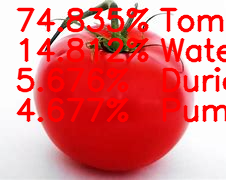

In [ ]:
from google.colab.patches import cv2_imshow

# Get the softmax probabilities.

probabilities2 = torch.nn.functional.softmax(out2, dim=1)[0]

# Check the top 5 categories that are predicted.

top4_prob, top4_catid = torch.topk(probabilities2, 4)




for i in range(top4_prob.size(0)):
    cv2.putText(img2, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img2, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())


    

cv2_imshow(img2)

cv2.waitKey(0)
cv2.destroyAllWindows()

Tomato 0.35324859619140625
Watermelon 0.24438314139842987
Pumpkin 0.22035034000873566
Durian 0.18201792240142822


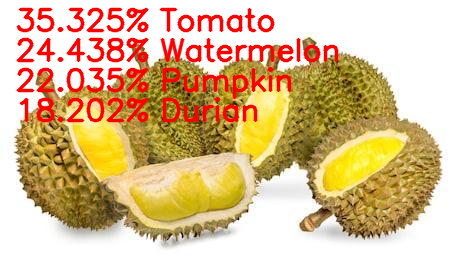

In [ ]:
from google.colab.patches import cv2_imshow

# Get the softmax probabilities.

probabilities3 = torch.nn.functional.softmax(out3, dim=1)[0]
# Check the top 5 categories that are predicted.

top4_prob, top4_catid = torch.topk(probabilities3, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img3, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img3, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()